# <span style="color:mediumvioletred"> **LAB 1  Optical Recognition of Handwritten Digits**</span>
### **Machine Learning**
Aissa Berenice Gonzalez Fosado 752224

<img src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal-Gris.png"  width="300">

Implementation of a two-layer perceptron (input and output) that recognizes handwritten digits from the UC Irvine – Machine Learning Repository dataset, located at:
https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwriting+digits

These are 8 x 8 images representing each of the 10 digits, along with the column with the correct category to which the image belongs. This data is also available in the scikit-learn dataset library in Python.

This lab contains two versions of the Perceptron: one "from scratch" using only Numpy, and another with the Perceptron library (linear models). This result will be compared to a multilayer perceptron (MLP) network with one or more hidden layers and at least two traditional machine learning algorithms (e.g., SVMs and Random Forest).We will measure the performance of these models, and in the case of neural networks, graph the learning curve over the number of training epochs.

In [9]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

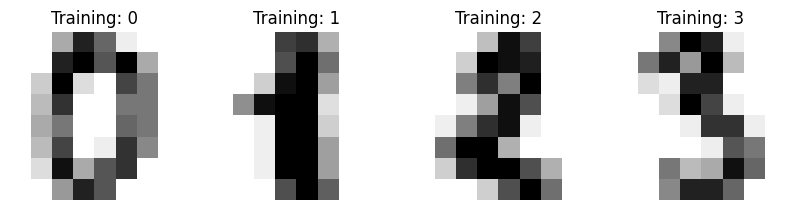

In [8]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


Learned weights: [-0.0987427  -0.00132105]
Learned bias:    0.0
Predictions on AND inputs: [1 0 0 0]
Errors per epoch: [3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


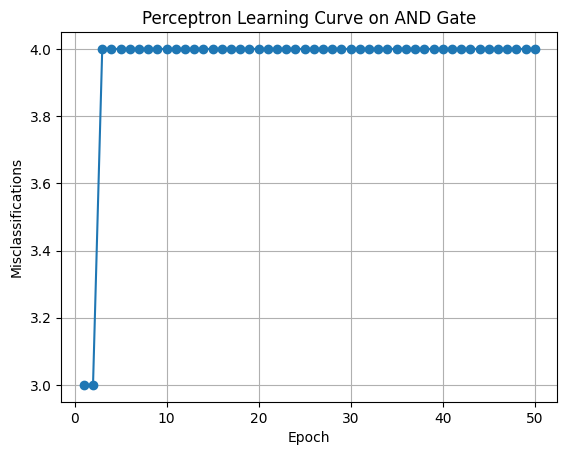

In [5]:
# Import datasets, classifiers and performance metrics
from sklearn.model_selection import train_test_split
# Perceptron for AND gate (NumPy) + learning curve plot (Matplotlib)

import numpy as np
import matplotlib.pyplot as plt

# ---- Data: AND gate ----
# Inputs (x1, x2) and targets y
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]], dtype=float)
y = np.array([0, 1, 1, 0], dtype=float)

# ---- Hyperparameters ----
lr = 0.1          # learning rate
max_epochs = 50   # safety cap; training will stop early when separable

# ---- Initialization ----
rng = np.random.default_rng(0)                  # reproducibility
w = rng.normal(0, 0.01, size=X.shape[1])        # small random weights
b = 0.0                                          # bias

def step(z: float) -> float:
    """Heaviside step activation."""
    return 1.0 if z >= 0 else 0.0

error_history = []  # number of misclassifications per epoch

# ---- Training loop (Perceptron Learning Rule) ----
for epoch in range(max_epochs):
    errors = 0
    for xi, target in zip(X, y):
        z = np.dot(xi, w) + b
        y_hat = step(z)
        update = lr * (target - y_hat)   # nonzero only when misclassified
        w += update * xi
        b += update
        errors += int(update != 0.0)
    error_history.append(errors)
    if errors == 0:   # perfectly classified => stop early
        break

# ---- Evaluate on training set ----
preds = np.array([step(np.dot(xi, w) + b) for xi in X])

print("Learned weights:", w)
print("Learned bias:   ", b)
print("Predictions on AND inputs:", preds.astype(int))
print("Errors per epoch:", error_history)

# ---- Plot learning curve ----
plt.figure()
plt.plot(range(1, len(error_history) + 1), error_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Misclassifications")
plt.title("Perceptron Learning Curve on AND Gate")
plt.grid(True)
plt.show()


## Perceptron using Scikit-Learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron